In [33]:
import sys, platform, torch

print("Python:", sys.version)
print("Platform:", platform.platform())
print("Torch:", torch.__version__)
print("Built CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
Torch: 2.8.0+cu128
Built CUDA: 12.8
CUDA available: True
Device: NVIDIA GeForce RTX 5060 Ti


In [34]:
import os, random, math
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import fingerprint_enhancer
import kornia.augmentation as K
import kornia.filters as KF

from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Config
data_dir = "./Mixed_Dataset"   # change if needed
img_size = (300, 400)          # (H, W)
batch_size = 64
num_classes = 4
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Prefer bf16 on Blackwell (RTX 50-series)
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
amp_dtype = torch.bfloat16 if use_bf16 else torch.float16
print("AMP dtype:", amp_dtype)


AMP dtype: torch.bfloat16


In [35]:
import torchvision.transforms as T

train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((img_size[0], img_size[1])),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((img_size[0], img_size[1])),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


Dataset Class Distribution:
a: 1722 images
ab: 1497 images
b: 1597 images
o: 1850 images


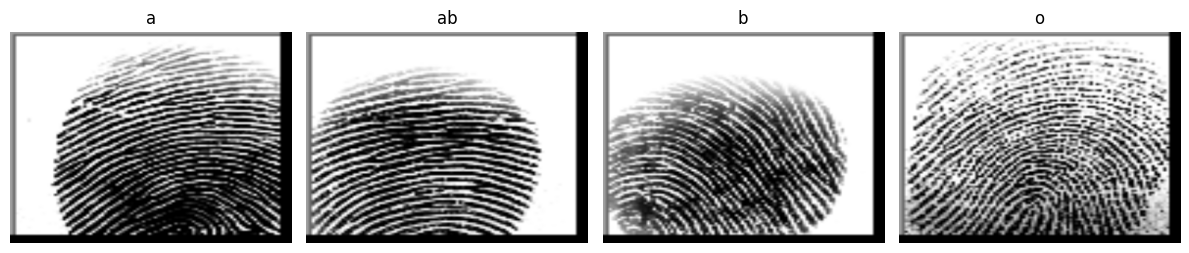

In [36]:
def display_dataset_info(data_root):
    class_names = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])
    class_count = {}
    for c in class_names:
        cpath = os.path.join(data_root, c)
        files = [f for f in os.listdir(cpath) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
        class_count[c] = len(files)

    print("Dataset Class Distribution:")
    for c, cnt in class_count.items():
        print(f"{c}: {cnt} images")

    # Show one sample per class
    plt.figure(figsize=(12, 8))
    show_idx = 1
    for c in class_names:
        cpath = os.path.join(data_root, c)
        files = [f for f in os.listdir(cpath) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
        if not files:
            continue
        sample = os.path.join(cpath, files[0])
        img = cv2.imread(sample)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size[1], img_size[0]))
        ax = plt.subplot(2, 4, show_idx)
        ax.imshow(img)
        ax.set_title(c)
        ax.axis("off")
        show_idx += 1
        if show_idx > 8:
            break
    plt.tight_layout()
    plt.show()

display_dataset_info(data_dir)


In [37]:
def apply_masked_processing(image: np.ndarray) -> np.ndarray:
    # Conservative binary mask at 160 to preserve ridges
    _, binary_mask = cv2.threshold(image, 160, 255, cv2.THRESH_BINARY_INV)
    blurred = cv2.GaussianBlur(image, (3, 3), 0.5)
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 8
    )
    enhanced_fp = cv2.bitwise_and(thresh, thresh, mask=binary_mask)
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_mask))
    final_image = cv2.add(enhanced_fp, background)
    if np.std(final_image) < 5:
        return image
    return final_image

def preprocess_image_np(path: str, img_size=(300, 400)) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Could not read image: {path}"
    img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_AREA)

    proc = apply_masked_processing(img)

    # Fingerprint enhancement with guards
    if np.std(proc) >= 10:
        try:
            enh = fingerprint_enhancer.enhance_fingerprint(proc)
            if enh is not None:
                if enh.dtype != np.uint8:
                    enh = np.clip(enh, 0, 255).astype(np.uint8)
                if np.std(enh) > 0:
                    proc = enh
        except Exception as e:
            print(f"Enhancement error for {os.path.basename(path)}: {e}")

    if proc.dtype != np.uint8:
        proc = np.clip(proc, 0, 255).astype(np.uint8)
    return proc

def preprocess_image_tensor(image_u8: np.ndarray) -> torch.Tensor:
    # Convert HxW uint8 to (1,H,W) float32 in [0,1]
    t = torch.from_numpy(image_u8).float() / 255.0
    return t.unsqueeze(0)


In [38]:
augment_pipeline = nn.Sequential(
    K.RandomRotation(degrees=10.0, p=0.9),
    K.ColorJitter(brightness=0.2, contrast=0.2, p=0.9),
).cpu()  # moved to device later


In [39]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class FingerprintDataset(Dataset):
    def __init__(self, data_dir, img_size=(300, 400), subset="train", val_split=0.2, transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.class_names = sorted(os.listdir(data_dir))
        self.class_indices = {c: i for i, c in enumerate(self.class_names)}
        self.transform = transform
        self.filepaths, self.labels = self._load_dataset(subset, val_split)

    def _load_dataset(self, subset, val_split):
        filepaths, labels = [], []
        for c in self.class_names:
            class_path = os.path.join(self.data_dir, c)
            image_files = [f for f in os.listdir(class_path)
                           if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
            image_paths = [os.path.join(class_path, f) for f in image_files]
            n_total = len(image_paths)
            n_val = int(n_total * val_split)
            if subset == "train":
                selected = image_paths[n_val:]
            else:
                selected = image_paths[:n_val]
            filepaths.extend(selected)
            labels.extend([self.class_indices[c]] * len(selected))
        return filepaths, labels

    def __len__(self):
        n = len(self.filepaths)
        
        if n == 0:
            print("Dataset empty; check data_dir and class folders.")
        return n
    

    #def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        #image_np = preprocess_image_np(img_path, img_size=self.img_size)
        #image_t = preprocess_image_tensor(image_np)  # (1,H,W)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        assert img is not None
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_AREA)
        image_t = torch.from_numpy(img).float().div_(255.0).unsqueeze(0)

        if self.transform:
            image_t = self.transform(image_t)
        return image_t, label
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        with Image.open(img_path) as pil:
            pil.load()  # force full read to avoid lazy I/O hangs
        # If BMP has palette or RGB, convert to 8-bit grayscale deterministically
        if pil.mode != "L":
            pil = pil.convert("L")
        pil = pil.resize((self.img_size[1], self.img_size[0]), Image.BILINEAR)
        img = np.asarray(pil, dtype=np.uint8)
        image_t = torch.from_numpy(img).float().div_(255.0).unsqueeze(0)
        label = self.labels[idx]
        return image_t, label


In [40]:
train_dataset = FingerprintDataset(data_dir, img_size, subset="train", transform=None)
val_dataset   = FingerprintDataset(data_dir, img_size, subset="val",   transform=None)

classes = train_dataset.class_names
print("Training samples per class:", Counter(train_dataset.labels))
print("Validation samples per class:", Counter(val_dataset.labels))

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    drop_last=True,
)
val_loader   = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    drop_last=False,
)

bad = []
from PIL import Image
for p in train_dataset.filepaths[:200]:  # sample first 200 to gauge
    try:
        with Image.open(p) as im:
            im.load()
    except Exception as e:
        bad.append((p, str(e)))
print("bad files:", len(bad))
if bad:
    print(bad[:5])

# Test immediately
it = iter(train_loader)
print("iter created instantly")
b = next(it)  
print("first batch fetched:", b[0].shape)

Training samples per class: Counter({3: 1480, 0: 1378, 2: 1278, 1: 1198})
Validation samples per class: Counter({3: 370, 0: 344, 2: 319, 1: 299})
bad files: 0
iter created instantly
first batch fetched: torch.Size([64, 1, 300, 400])


In [41]:
print("classes:", os.listdir(data_dir)[:5])
p = train_dataset.filepaths[0]; print("probe:", p)
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE); print("img:", type(img), img.shape if img is not None else None)


classes: ['a', 'ab', 'b', 'o']
probe: ./Mixed_Dataset\a\cluster_0_4248.BMP
img: <class 'numpy.ndarray'> (103, 96)


In [42]:
class_labels = np.array(train_dataset.labels)
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)


In [43]:
class FingerprintCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size[0]//8) * (img_size[1]//8), 128),
            nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

model = FingerprintCNN(num_classes=num_classes).to(device)
print(model)


FingerprintCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=236800, out_features=128, bias=True)
    (2): ReLU()
    (3):

In [44]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction="none", weight=class_weights)
        pt = torch.exp(-ce)
        loss = self.alpha * (1 - pt) ** self.gamma * ce
        return loss.mean() if self.reduction == "mean" else loss.sum()

criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Enable GradScaler only for fp16 (bf16 doesn’t need scaling)
scaler = torch.cuda.amp.GradScaler("cuda", enabled=(torch.cuda.is_available() and not use_bf16))

# Keep Kornia augmentations on GPU to avoid per-batch transfers
augment_pipeline.to(device)


C:\Users\Tian\AppData\Local\Temp\ipykernel_21496\4283429482.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler("cuda", enabled=(torch.cuda.is_available() and not use_bf16))


Sequential(
  (0): RandomRotation(degrees=10.0, p=0.9, p_batch=1.0, same_on_batch=False, resample=bilinear, align_corners=True)
  (1): ColorJitter(brightness=0.2, contrast=0.2, saturation=0.0, hue=0.0, p=0.9, p_batch=1.0, same_on_batch=False)
)

Visualizing preprocessing on sample images:

=== Class: a ===


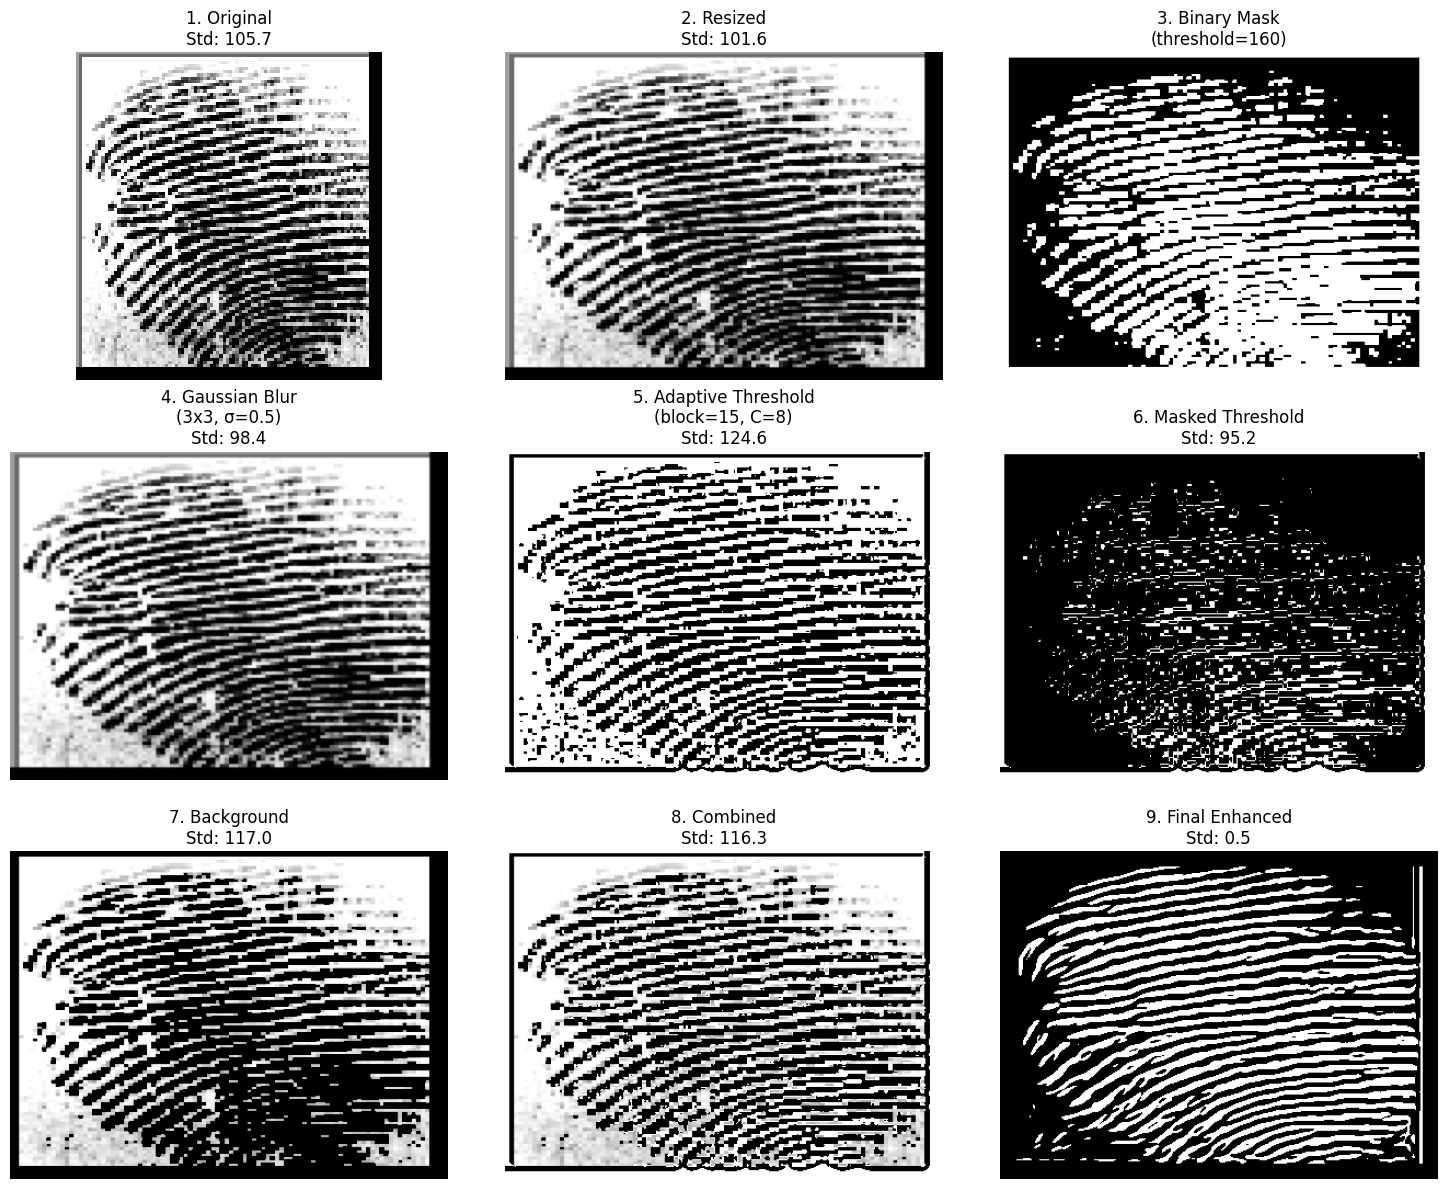


Processing Statistics for: cluster_0_4248.BMP
Original std: 105.70
Final std: 0.47
Improvement: 0.00x
Enhanced by fingerprint_enhancer: Yes

=== Class: ab ===


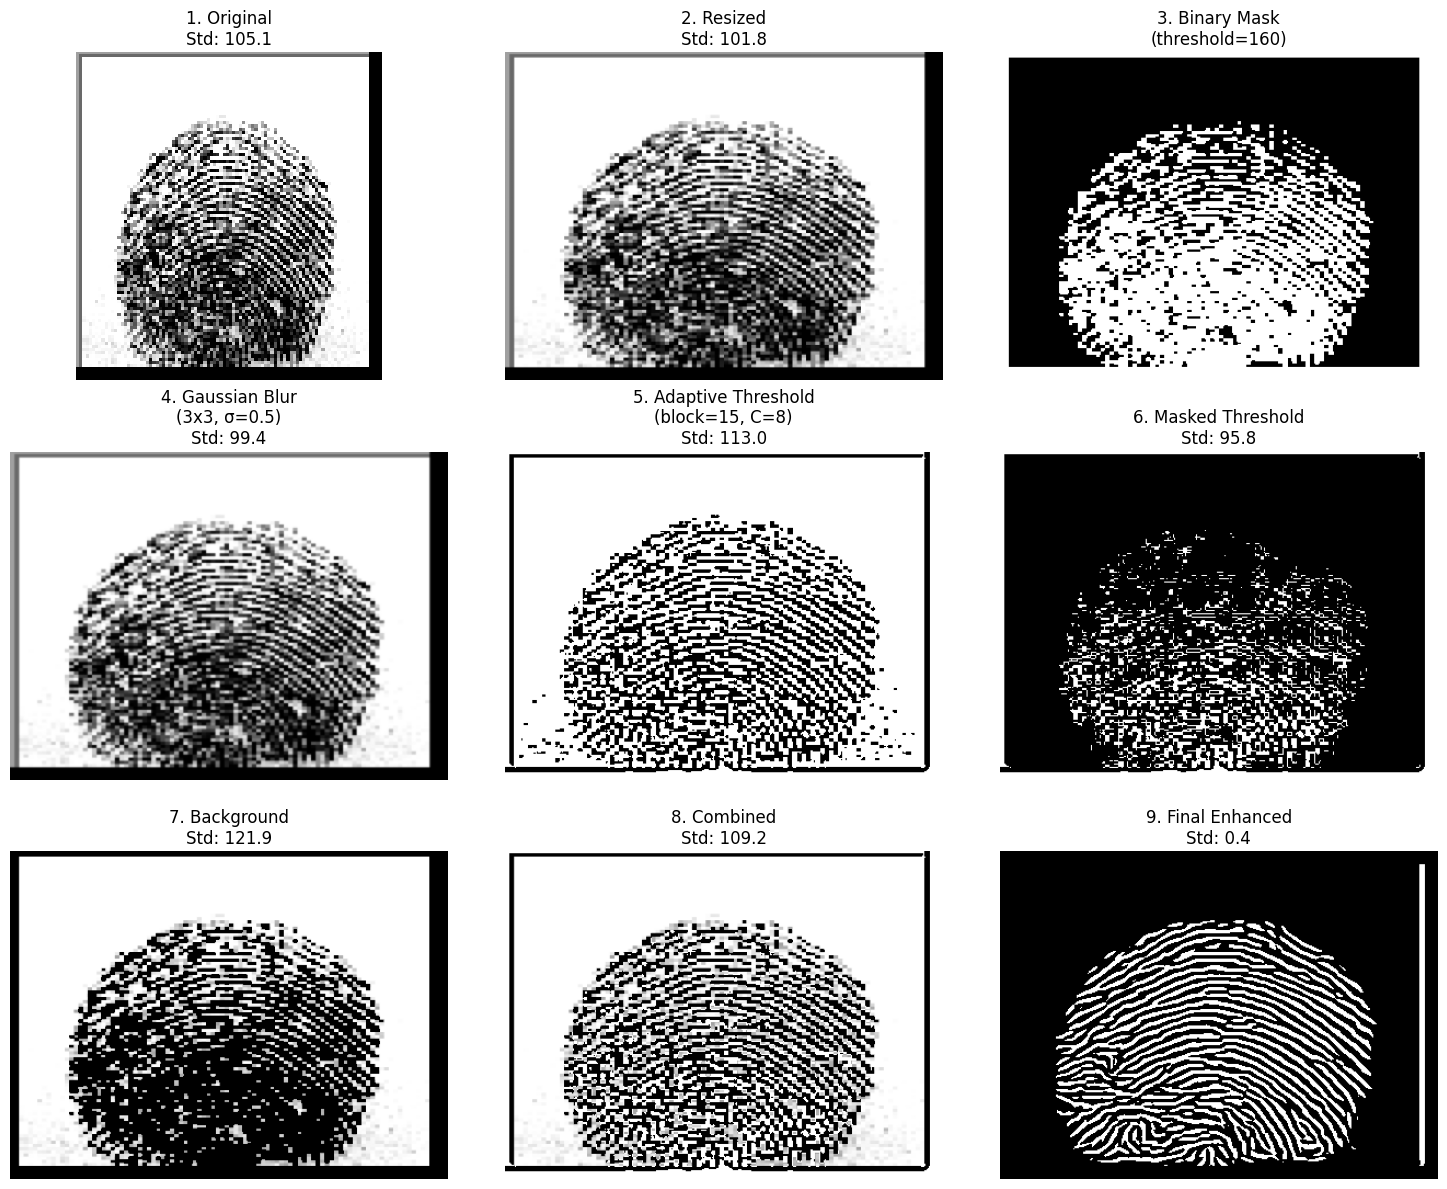


Processing Statistics for: cluster_4_3254.BMP
Original std: 105.12
Final std: 0.40
Improvement: 0.00x
Enhanced by fingerprint_enhancer: Yes


In [45]:
#Visualize Preprocessing
def visualize_preprocessing_steps(img_path, img_size=(300, 400)):
    """Visualize each step of the preprocessing pipeline"""
    import matplotlib.pyplot as plt
    
    # Read original image
    original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if original is None:
        print(f"Could not read: {img_path}")
        return
    
    resized = cv2.resize(original, (img_size[1], img_size[0]), interpolation=cv2.INTER_AREA)
    
    # Step 1: Binary mask creation
    _, binary_mask = cv2.threshold(resized, 160, 255, cv2.THRESH_BINARY_INV)
    
    # Step 2: Gaussian blur
    blurred = cv2.GaussianBlur(resized, (3, 3), 0.5)
    
    # Step 3: Adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 8
    )
    
    # Step 4: Apply mask to thresholded image
    enhanced_fp = cv2.bitwise_and(thresh, thresh, mask=binary_mask)
    
    # Step 5: Keep original background
    background = cv2.bitwise_and(resized, resized, mask=cv2.bitwise_not(binary_mask))
    
    # Step 6: Combine enhanced foreground + original background
    masked_result = cv2.add(enhanced_fp, background)
    
    # Step 7: Fingerprint enhancement (if applicable)
    enhanced_final = None
    if np.std(masked_result) >= 10:
        try:
            enhanced_final = fingerprint_enhancer.enhance_fingerprint(masked_result)
            if enhanced_final is not None:
                if enhanced_final.dtype != np.uint8:
                    enhanced_final = np.clip(enhanced_final, 0, 255).astype(np.uint8)
        except Exception as e:
            print(f"Enhancement failed: {e}")
            enhanced_final = masked_result
    else:
        enhanced_final = masked_result
    
    # Create visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # Row 1: Original processing steps
    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title(f'1. Original\nStd: {np.std(original):.1f}')
    axes[0,0].axis('off')
    
    axes[0,1].imshow(resized, cmap='gray')
    axes[0,1].set_title(f'2. Resized\nStd: {np.std(resized):.1f}')
    axes[0,1].axis('off')
    
    axes[0,2].imshow(binary_mask, cmap='gray')
    axes[0,2].set_title('3. Binary Mask\n(threshold=160)')
    axes[0,2].axis('off')
    
    # Row 2: Processing steps
    axes[1,0].imshow(blurred, cmap='gray')
    axes[1,0].set_title(f'4. Gaussian Blur\n(3x3, σ=0.5)\nStd: {np.std(blurred):.1f}')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(thresh, cmap='gray')
    axes[1,1].set_title(f'5. Adaptive Threshold\n(block=15, C=8)\nStd: {np.std(thresh):.1f}')
    axes[1,1].axis('off')
    
    axes[1,2].imshow(enhanced_fp, cmap='gray')
    axes[1,2].set_title(f'6. Masked Threshold\nStd: {np.std(enhanced_fp):.1f}')
    axes[1,2].axis('off')
    
    # Row 3: Final steps
    axes[2,0].imshow(background, cmap='gray')
    axes[2,0].set_title(f'7. Background\nStd: {np.std(background):.1f}')
    axes[2,0].axis('off')
    
    axes[2,1].imshow(masked_result, cmap='gray')
    axes[2,1].set_title(f'8. Combined\nStd: {np.std(masked_result):.1f}')
    axes[2,1].axis('off')
    
    axes[2,2].imshow(enhanced_final, cmap='gray')
    axes[2,2].set_title(f'9. Final Enhanced\nStd: {np.std(enhanced_final):.1f}')
    axes[2,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nProcessing Statistics for: {os.path.basename(img_path)}")
    print(f"Original std: {np.std(original):.2f}")
    print(f"Final std: {np.std(enhanced_final):.2f}")
    print(f"Improvement: {np.std(enhanced_final)/np.std(original):.2f}x")
    print(f"Enhanced by fingerprint_enhancer: {'Yes' if enhanced_final is not masked_result else 'No'}")
    
    return {
        'original': original,
        'resized': resized,
        'binary_mask': binary_mask,
        'blurred': blurred,
        'thresh': thresh,
        'enhanced_fp': enhanced_fp,
        'background': background,
        'masked_result': masked_result,
        'enhanced_final': enhanced_final
    }

# Test on a few sample images from different classes
print("Visualizing preprocessing on sample images:")
for i, class_name in enumerate(train_dataset.class_names[:2]):  # First 2 classes
    class_samples = [p for p, l in zip(train_dataset.filepaths, train_dataset.labels) if l == i]
    if class_samples:
        print(f"\n=== Class: {class_name} ===")
        result = visualize_preprocessing_steps(class_samples[0])


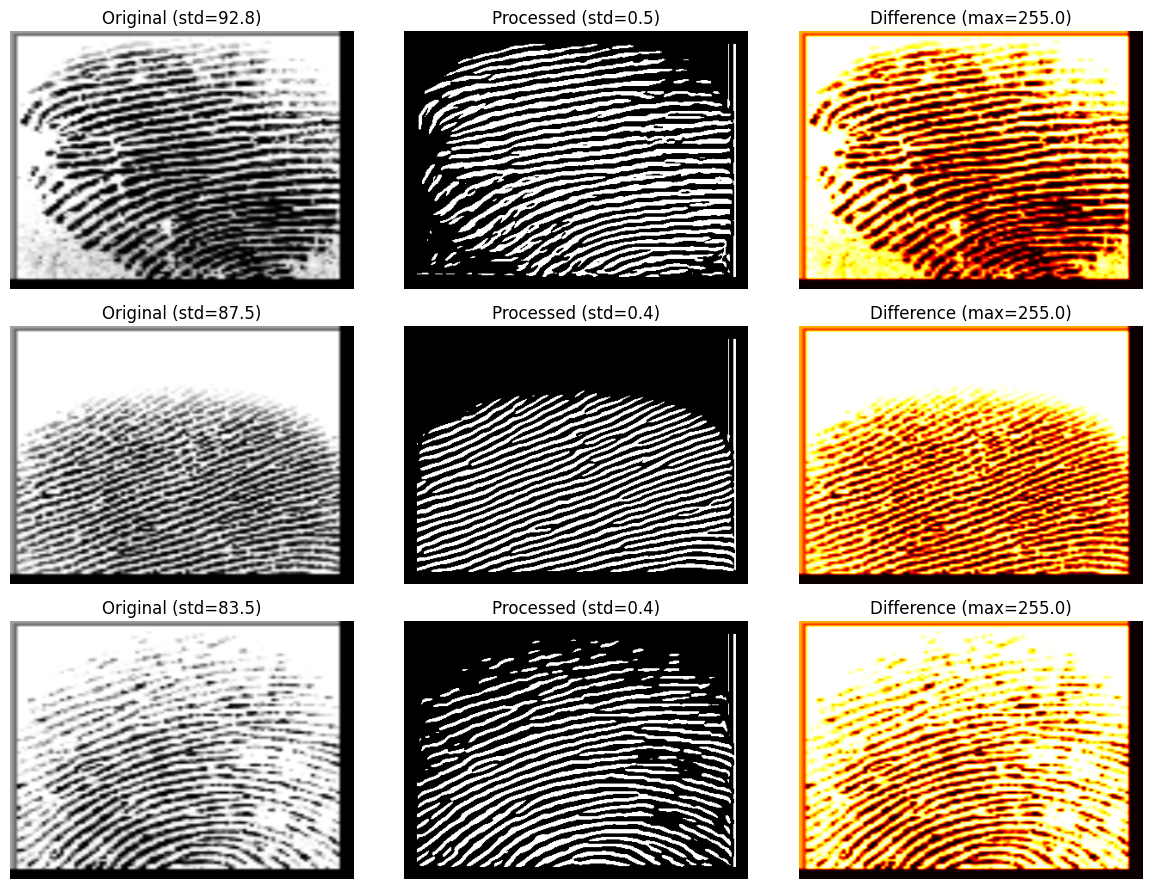

In [46]:
# Compare multiple images from the same class
def compare_preprocessing_across_samples(class_idx=0, num_samples=4):
    """Compare preprocessing results across multiple samples from the same class"""
    class_samples = [p for p, l in zip(train_dataset.filepaths, train_dataset.labels) if l == class_idx][:num_samples]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3*num_samples))
    
    for i, sample_path in enumerate(class_samples):
        # Original
        original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
        original = cv2.resize(original, (img_size[1], img_size[0]))
        
        # Processed
        processed = preprocess_image_np(sample_path)
        
        # Difference
        diff = np.abs(processed.astype(float) - original.astype(float))
        
        axes[i,0].imshow(original, cmap='gray')
        axes[i,0].set_title(f'Original (std={np.std(original):.1f})')
        axes[i,0].axis('off')
        
        axes[i,1].imshow(processed, cmap='gray')
        axes[i,1].set_title(f'Processed (std={np.std(processed):.1f})')
        axes[i,1].axis('off')
        
        axes[i,2].imshow(diff, cmap='hot')
        axes[i,2].set_title(f'Difference (max={diff.max():.1f})')
        axes[i,2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Compare samples from first class
compare_preprocessing_across_samples(class_idx=0, num_samples=3)


In [47]:
from time import time as _now

def train_one_epoch(loader):
    print("train_one_epoch: starting")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for i, (images, labels) in enumerate(loader):
        if i == 0:
            print("got first batch")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for i, (images, labels) in enumerate(loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(dtype=torch.long, device=device)

        optimizer.zero_grad(set_to_none=True)
        # Autocast uses preferred dtype (bf16 on Blackwell)
        if device.type == "cuda":
            ctx = torch.autocast(device_type="cuda", dtype=amp_dtype)
        else:
            # no-op context
            from contextlib import nullcontext
            ctx = nullcontext()

        with ctx:
            images = augment_pipeline(images)  # Kornia ops on GPU
            outputs = model(images)
            loss = criterion(outputs, labels)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Lightweight liveness log every ~50 batches
        if (i + 1) % 50 == 0:
            print(f"iter {i+1}/{len(loader)} | loss {total_loss/(i+1):.4f} | acc {correct/max(1,total):.4f}")

    return total_loss / max(1, len(loader)), correct / max(1, total)

@torch.no_grad()
def validate(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=False)
        labels = labels.to(dtype=torch.long, device=device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / max(1, len(loader)), correct / max(1, total)


In [48]:
# Time a single file read outside PyTorch
import time
p = train_dataset.filepaths[0]
start = time.time()
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
print(f"Single file read: {time.time() - start:.2f}s")


Single file read: 0.00s


In [ ]:
epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print("Using device:", device)
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_one_epoch(train_loader)
    va_loss, va_acc = validate(val_loader)

    train_losses.append(tr_loss); train_accuracies.append(tr_acc)
    val_losses.append(va_loss);   val_accuracies.append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss={tr_loss:.4f}, Acc={tr_acc:.4f} "
          f"| Val Loss={va_loss:.4f}, Acc={va_acc:.4f}")

Using device: cuda
train_one_epoch: starting
got first batch
iter 50/83 | loss 0.1693 | acc 0.5119
Epoch 01 | Train Loss=0.1457, Acc=0.5587 | Val Loss=0.1134, Acc=0.5045
train_one_epoch: starting
got first batch
iter 50/83 | loss 0.0930 | acc 0.6897
Epoch 02 | Train Loss=0.0890, Acc=0.6926 | Val Loss=0.0999, Acc=0.6081
train_one_epoch: starting
got first batch
